<a href="https://colab.research.google.com/github/alfiinyang/Text2Excel/blob/main/text2excel_1.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text to Excel

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Extract Data from the Existing Spreadsheet
Load the data from the existing spreadsheet into a DataFrame.

In [ ]:
!pip install openpyxl
!pip install transformers[torch]

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import pandas as pd

# Load existing Excel file
# file_path = r'C:\Users\ISLP11\Downloads\cash_flow.xlsx'
df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/text2excel/cash_flow_CAH.csv', parse_dates = ['DATE'], encoding='ISO-8859-1')
df2 = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/text2excel/cash_flow_access.csv', parse_dates = ['DATE'], encoding='ISO-8859-1')

# Ensure the DataFrame contains the required columns
df = df[['COMMENT', 'CATEGORY']]
df2 = df2[['COMMENT', 'CATEGORY']]

print(df.head(), df2.head())

<ipython-input-66-357ec6ce81ec>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/text2excel/cash_flow_CAH.csv', parse_dates = ['DATE'], encoding='ISO-8859-1')


                   COMMENT  CATEGORY
0             POS cash out  CASH OUT
1       Lunch: Ogbono soup      FOOD
2                     Fufu      FOOD
3  Insecticide: knock down   UTILITY
4               Cleaner TP    GIVING                    COMMENT  CATEGORY
0  Second account transfer  CASH OUT
1          Transfer charge   CHARGES
2     Card maintenance fee   CHARGES
3          Etenwan lending      LOAN
4                  Haircut   UTILITY


<ipython-input-66-357ec6ce81ec>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2 = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/text2excel/cash_flow_access.csv', parse_dates = ['DATE'], encoding='ISO-8859-1')


In [ ]:
df.isna().sum(), df2.isna().sum()

(COMMENT     38
 CATEGORY    38
 dtype: int64,
 COMMENT     44
 CATEGORY    44
 dtype: int64)

In [ ]:
df.dropna(inplace=True), df2.dropna(inplace=True)

<ipython-input-68-8a915bc3fa87>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True), df2.dropna(inplace=True)


(None, None)

In [ ]:
dfT=pd.concat([df, df2])
dfT.shape, df.shape, df2.shape
dfT.head()

,COMMENT,CATEGORY
0,POS cash out,CASH OUT
1,Lunch: Ogbono soup,FOOD
2,Fufu,FOOD
3,Insecticide: knock down,UTILITY
4,Cleaner TP,GIVING


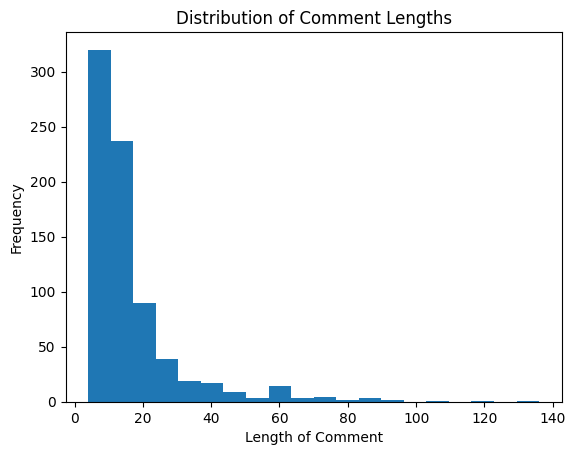

In [ ]:
max_l = lambda x: max([len(x) for x in x])
maxin = max_l(dfT['COMMENT'])
mal_i = lambda x: [len(x) for x in x]
spread = mal_i(dfT['COMMENT'])

import matplotlib.pyplot as plt
plt.hist(spread, bins = 20)
plt.xlabel('Length of Comment')
plt.ylabel('Frequency')
plt.title('Distribution of Comment Lengths')
plt.show()

In [ ]:
import numpy as np

# Calculate the 95th percentile
max_length = int(np.percentile(spread, 95))
print(f"95th percentile of comment lengths: {max_length}")


95th percentile of comment lengths: 45


## 2. Preprocess the Data
Prepare the data for training by splitting it into training and validation sets.

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_df, val_df = train_test_split(dfT, test_size=0.2, random_state=42)

# Reset the index of the DataFrames
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

## 3.1 Train a Text Classification Model
Fine-tune a pre-trained model like BERT using Hugging Face's transformers library.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import torch
from torch.utils.data import Dataset

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.texts = dataframe['COMMENT'].tolist()
        self.labels = dataframe['CATEGORY'].astype('category').cat.codes.tolist() # convert categories to int codes
        self.max_len = max_len
        self.label_map = {i: c for i, c in enumerate(dataframe['CATEGORY'].astype('category').cat.categories)}  # map categories to int codes

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 45 #128

# Create the custom datasets
train_dataset = CustomDataset(train_df, tokenizer, max_len)
val_dataset = CustomDataset(val_df, tokenizer, max_len)

# Initialize the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(train_df['CATEGORY'].unique()))

# Define training arguments
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Colab Notebooks/text2excel/results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/Colab Notebooks/text2excel/logs',
    logging_steps=10,
    evaluation_strategy='steps',
    save_total_limit=1,
    save_steps=500,
    eval_steps=500,
    load_best_model_at_end=True
)

# Define data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer
)

# Train the model
trainer.train()

Step,Training Loss,Validation Loss


## 3.2 Train a Text Classification Model with Sliding Window Approach for Handling Longer Sequences
Fine-tune a pre-trained model like BERT using Hugging Face's transformers library.

In [ ]:
### code supporting text chunk processing

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import torch
from torch.utils.data import Dataset

# Define a custom dataset class
class CustomDataset2(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, stride):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.texts = dataframe['COMMENT'].tolist()
        self.labels = dataframe['CATEGORY'].astype('category').cat.codes.tolist()
        self.max_len = max_len
        self.stride = stride # chunk slider
        self.label_map = {i: c for i, c in enumerate(dataframe['CATEGORY'].astype('category').cat.categories)}

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        # Tokenize and split the text into chunks using the sliding window approach
        tokens = self.tokenizer.tokenize(text)
        chunks = []
        for i in range(0, len(tokens), self.stride):
            chunk = tokens[i:i + self.max_len]
            if len(chunk) == 0:
                break
            chunk = self.tokenizer.convert_tokens_to_ids(chunk)
            chunk = self.tokenizer.build_inputs_with_special_tokens(chunk)
            if len(chunk) > self.max_len:
                chunk = chunk[:self.max_len-1] + [self.tokenizer.sep_token_id]
            chunks.append(chunk)

        # Create a tensor for each chunk
        encodings = []
        attention_masks = []
        for chunk in chunks:
            encoding = torch.tensor(chunk, dtype=torch.long)
            attention_mask = torch.ones(len(chunk), dtype=torch.long)
            padding_length = self.max_len - len(chunk)
            if padding_length > 0:
                encoding = torch.cat((encoding, torch.zeros(padding_length, dtype=torch.long)))
                attention_mask = torch.cat((attention_mask, torch.zeros(padding_length, dtype=torch.long)))
            encodings.append(encoding)
            attention_masks.append(attention_mask)

        # Combine all chunk encodings and attention masks into a single tensor
        encodings = torch.stack(encodings)
        attention_masks = torch.stack(attention_masks)

        return {
            'text': text,
            'input_ids': encodings,
            'attention_mask': attention_masks,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 45
stride = 30

# Create the custom datasets
train_dataset_2 = CustomDataset2(train_df, tokenizer, max_len, stride)
val_dataset_2 = CustomDataset2(val_df, tokenizer, max_len, stride)

In [ ]:
# Initialize the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(train_df['CATEGORY'].unique()))

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='steps',
    save_total_limit=1,
    save_steps=500,
    eval_steps=500,
    load_best_model_at_end=True
)

# Define data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_2,
    eval_dataset=val_dataset_2,
    data_collator=data_collator,
    tokenizer=tokenizer
)

# Train the model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


ValueError: too many values to unpack (expected 2)

## 4. Save the Trained Model and Label Map
Save the model and the label map for future use.

In [ ]:
iterr_ = 0
mod = '/content/drive/MyDrive/Colab Notebooks/text2excel/mod_iter/t2e_cat_class_model'

In [ ]:
iterr_ += 0.1
mod = mod + str(iterr_)

In [ ]:
model.save_pretrained(mod)
tokenizer.save_pretrained(mod)

('/content/drive/MyDrive/Colab Notebooks/text2excel/mod_iter/t2e_cat_class_model0.1/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/text2excel/mod_iter/t2e_cat_class_model0.1/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/text2excel/mod_iter/t2e_cat_class_model0.1/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/text2excel/mod_iter/t2e_cat_class_model0.1/added_tokens.json')

In [ ]:
import json

# Save the label map to a JSON file
with open('/'.join([mod, 'label_map.json']), 'w') as file:
    json.dump(train_dataset.label_map, file)

## 5. Integrate the Trained Model
Use the trained model to classify new descriptions.

In [3]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import json

iterr_ = 0
mod = '/content/drive/MyDrive/Colab Notebooks/text2excel/mod_iter/t2e_cat_class_model'
iterr_ += 0.1
mod = mod + str(iterr_)

# Load the label map from the JSON file
with open('/'.join([mod,'label_map.json']), 'r') as file:
    label_map = json.load(file)

# Load the trained model and tokenizer
model = BertForSequenceClassification.from_pretrained(mod)
tokenizer = BertTokenizer.from_pretrained(mod)
max_len = 45

# Define a function to classify a new description
def classify_description(description):
    with torch.no_grad():
        encoding = tokenizer.encode_plus(
            description,
            add_special_tokens=True,
            max_length=max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        outputs = model(input_ids, attention_mask=attention_mask)
        _, prediction = torch.max(outputs.logits, dim=1)
        return label_map[str(prediction.item())]

In [4]:
# Example usage
new_description = "Meat, ikpa, stockfish, dry fish, afang, crayfish, waterleaf, black bag, grinding, onions, pepper, banana, plantain"
category = classify_description(new_description)
print(f'The category for "{new_description}" is {category}.')

The category for "Meat, ikpa, stockfish, dry fish, afang, crayfish, waterleaf, black bag, grinding, onions, pepper, banana, plantain" is FOOD.


### Text2Excel

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Create a Textarea widget
textarea = widgets.Textarea(
    value='',
    placeholder='Type your text here',
    description='Text:',
    # layout=widgets.Layout(width='50%', height='100px')
)

# Display the widget
# print("\033[1m"+"Insert transaction details")
# display(textarea)

# Function to capture the text when a button is pressed
def capture_text(textarea = textarea):
    return textarea.value

# Initialize a variable to store the text
captured_text = ""

# Function to handle button click event and store the captured text
click_flag = False

def on_button_click(b, textarea = textarea):
    global captured_text
    global click_flag
    captured_text = ""
    captured_text = capture_text()
    click_flag = True
    # print("\nCollected text:")
    # print(captured_text)
    # Disable the button
    b.disabled = True
    b.description = "Submitted"


# Function to capture the text when a button is pressed
# def capture_text(b):
#     global text
#     text = textarea.value
#     print("\033[1m"+info+"\033[0m")
#     # Disable the button
#     b.disabled = True
#     b.description = "Submitted"
#     # print(text)

# Create and display a button widget
button = widgets.Button(description="Submit")
# info = "Transaction details:"
# button.on_click(capture_text)
# display(button)

In [ ]:
def new_input(in_type, w="50%", h="100px", textarea = textarea):
  #
  # file_path = input("XL file path: ")
  # sheet_name = input("Sheet name (BLOCK LETTERS):")
  textarea.value = ""
  global click_flag
  click_flag = False

  # Display the widget
  print("\033[1m"+in_type+"\033[0m")
  textarea.layout = widgets.Layout(width=w, height=h)
  display(textarea)

  # display a button widget
  info = "Transaction details:"
  button.on_click(lambda b: on_button_click(b,textarea))
  textarea.value = ""
  display(button)
  button.disabled = False
  button.description = "Submit"
  return textarea

  # return file_path, sheet_name

Test button and stored var

In [ ]:
a = new_input("Insert transaction details", '50%', '100px')

Insert transaction details


Textarea(value='', description='Text:', layout=Layout(height='100px', width='50%'), placeholder='Type your tex…

Button(description='Submitted', disabled=True, style=ButtonStyle())

In [ ]:
captured_text

'Bshshs'

Implement button in `txt2xl`

In [ ]:
import re
import time
import pandas as pd
from openpyxl import load_workbook

def txt2xl(intext = textarea):

  global captured_text

  flag = True
  click_flag = False
  ct = captured_text
  textarea = new_input("Insert transaction details", '50%', '100px', textarea = textarea)
  tt = 0



  while flag:
    tt+=1
    if tt%1000==1:
         print(tt)
         time.sleep(1)


    click_flag = ct != captured_text

    if click_flag:
      print(f"click flag is: {click_flag}")
      ct = captured_text

      input_text = captured_text #textarea.value

      # Regular expression patterns
      date_pattern = r'\d{2}/\d{2}/\d{4}'
      entry_pattern1 = r'([\w\s,()]+)'
      entry_pattern2 = r'([\w\s,()]+) - ([\d, ]+)'

      # Extract date
      date = re.search(date_pattern, input_text).group()

      # Extract entries
      entries = input_text[len(date)+1:].strip().split('\n')

      for i, entry in enumerate(entries):
        if re.findall(entry_pattern2, entry) == []:
          desc = re.findall(entry_pattern1, entry)[0]
          if desc.lower().endswith('cash out'):
            desc = 'POS cash out'
            cost = re.findall(r'\d+', entry)[0]+'000'
          else:
            cost = '0'
          entries[i] = date, desc, cost, classify_description(desc)
        else:
          desc, cost = re.findall(entry_pattern2, entry)[0]
          entries[i] = date, desc, cost, classify_description(desc)

      # store entries in a DatatFrame
      data = []
      for date, item, cost, category in entries:
        total_cost = '=SUM('+cost+')'
        if item == 'POS cash out':
          data.append([date, item, total_cost, '', category])
        else:
          data.append([date, item, '', total_cost, category])

      new_df = pd.DataFrame(data, columns=['DATE', 'COMMENT', 'CREDIT', 'DEBIT', 'CATEGORY'])
      new_df['DATE'] = pd.to_datetime(new_df.DATE, dayfirst = True)
      new_df['DATE'] = new_df.DATE.dt.date

      # print("\033[1m"+"Transaction details:\n"+"\033[0m")
      # display(new_df)

    # old_sheet = pd.read_excel(file_path, sheet_name=sheet_name, converters={'BALANCE': str})
    # pd.concat([old_sheet, new_df]).to_excel('/content/drive/MyDrive/Colab Notebooks/text2excel/cash_flow_edit2.xlsx', index=False, sheet_name=sheet_name)

    # def save_opt(textarea=textarea):
      # save_ = input("Save? (y/n): ")

      # if save_.lower() == 'n':
      #   textarea = new_input("Insert transaction details", '50%', '100px', textarea = textarea)
      #   # textarea = txt2xl(textarea = textarea)
      # elif save_.lower() == 'y':
      #   flag = False
      #   save_at = input("save at: ")
      #   new_df.to_excel(save_at, index=False)
      #   print("Saved!")
      # else:
      #   print("Invalid input")
    #     save_opt()

    # save_opt()
  return new_df

In [ ]:
"""
11/04/2024
10k cash out
Eneka tp (2) - 200, 300, 200, 400, 600
Office TP - 650, 200
Watermelon, pineapple, coconut - 200, 300, 600
TP home - 450
"""

"""
10/04/2024
Office TP - 700
10k cash out
Shoe shine - 800
Meat, stockfish, dried fish, curry, ginger, garlic, water leaf, afang, crayfish, grinding, bell pepper (2), fresh pepper, fresh tomatoes - 2500, 700, 500, 100, 100, 100, 750, 400, 100, 1000, 100, 500
TP home - 400, 100, 300
Fufu (4), chi exotic - 400, 1200
Toothbrush - 250
"""
save_at = '/content/drive/MyDrive/Colab Notebooks/text2excel/cash_flow_edit2.xlsx'

### Adding this to solve the challenge
- godswill

In [ ]:
import threading
import time
import pandas as pd
import numpy as np
from IPython.display import display, clear_output
import ipywidgets as widgets

### Text2Excel psuedo (`process_text()`)

In [40]:
import pandas as pd
import re

def process_text(input_text):
    # Regular expression patterns
    date_pattern = r'\d{2}/\d{2}/\d{4}'
    entry_pattern1 = r'([\w\s,()]+)'
    entry_pattern2 = r'([\w\s,()]+) - ([\d, ]+)'

    t_entries = input_text.split('\n\n')
    data = []


    # Extract entries by date
    for line in t_entries:
      # Extract date
      date = re.search(date_pattern, line).group()

      # Extract entries
      entries = line[len(date)+1:].strip().split('\n')

      for i, entry in enumerate(entries):
          if re.findall(entry_pattern2, entry) == []:
              desc = re.findall(entry_pattern1, entry)[0]
              if desc.lower().strip().endswith('cash out'):
                  desc = 'POS cash out'
                  cost = re.findall(r'\d+', entry)[0] + '000'
              else:
                  cost = '0'
              entries[i] = date, desc, cost#, classify_description(desc)
          else:
              desc, cost = re.findall(entry_pattern2, entry)[0]
              entries[i] = date, desc, cost#, classify_description(desc)

      # Store entries in a DataFrame
      for date, item, cost in entries:
          total_cost = '=SUM(' + cost + ')'
          if item == 'POS cash out':
              data.append([date, item, total_cost, '', '', ''])
          else:
              data.append([date, item, '', total_cost, '', ''])

    new_df = pd.DataFrame(data, columns=['DATE', 'COMMENT', 'CREDIT', 'DEBIT', 'SOURCE', 'CATEGORY'])
    new_df['DATE'] = pd.to_datetime(new_df.DATE, dayfirst=True)
    new_df['DATE'] = new_df.DATE.dt.date
    new_df['CATEGORY'] = new_df.COMMENT.map(classify_description)

    return new_df

In [41]:
mmm = """30/06/2024
10k cash out
Water (2), pap (2), egg (6), coke - 700, 200, 1200, 300

01/07/2024
Bread, fufu (3), tigernut - 900, 300, 200
Office TP - 700
TP home - 100

02/07/2024
ORS, flagyl - 250, 500
Office TP - 450
TP home - 100

03/07/2024
Fufu (3) - 300
Office TP - 600
TP home - 100

04/07/2024
Office TP - 600
Tigernut - 200
Chinonso - 100
TP home - 100

05/07/2024
Office TP - 450
TP home - 100
Orange (3) - 200

06/07/2024
Bread, pap (3) - 850, 300
10k cash out

08/07/2024
Office TP - 600
TP home - 100

09/07/2024
Fufu (3) - 300
Office TP - 600
TP home - 100

10/07/2024
Fufu (3) - 300
Office TP - 600
Passenger assist - 100
TP home - 100
Bread, milk (2) - 850, 1000

11/07/2024
Fufu (3) - 300
Office TP - 600
TP home - 100

12/07/2024
Fufu (4) - 400
Office TP - 700
TP home - 600

13/07/2024
Ecogas TP - 400

15/07/2024
Office TP - 600
TP home - 200
Passenger TP - 100

16/07/2024
10k cash out
Office TP - 600
Fufu (4) - 400
TP home - 100

17/07/2024
Office TP - 600
Lunch (tigernut, small chops (2), yam/potato and sauce) - 2000
TP home - 100
Bread, banana - 800, 400

18/07/2024
Office TP - 600
TP home - 600
Meat, ikpa, stockfish, dry fish, afang, crayfish, waterleaf, black bag, grinding, onions, pepper, banana, plantain - 2000, 1000, 2300, 500, 600, 100, 400, 100, 100, 1500, 1000, 1500, 2000

19/07/2024
Fufu (3) - 300
Office TP - 600
TP home - 100

20/07/2024
10k cash out

21/07/2024
Disandat TP - 100
Water, Star beer - 300, 800
TP home - 200

22/07/2024
Fufu (5), malt (2) - 500, 1200
Trash disposal - 200
Chidera TP - 500

23/07/2024
Office TP - 600
TP home - 100
Fufu (9) - 900

24/07/2024
Office TP - 600
TP home - 100
Neighbour TP - 100
Bread, groundnut - 850, 2500

25/07/2024
Office TP - 700
TP home - 100

26/07/2024
10k cash out
Tomatoes, pepper, bell pepper, ginger, meat, grinding, water (2 + 4 sachets) - 3000, 1000, 1000, 100, 2000, 200, 800
TP home - 200

27/07/2024
Haircut - 500

29/07/2024
10k cash out
Fufu (3) - 300
Office TP - 700
Shortbread (200 change left) - 2200
TP home - 200
Bread, chi exotic - 950, 600

30/07/2024
Office TP - 700
TP home - 100
Ecogas TP - 500

31/07/2024
Bread - 950
Office TP - 800
TP home - 100
Stock fish, dried fish, meat, crayfish, ikpa, okra, ugwu, pepper, grinding - 400, 600, 2000, 600, 1000, 600, 100, 500, 100
Condom (3) - 2100
Vitamin c - 200
Chidera TP - 1000

01/08/2024
Office TP - 700
TP home - 200
Bread - 950

05/08/2024
10k cash out
Milk, pap (4), smoove (2) - 800, 400, 500

06/08/2024
Bread, Maltina - 950, 600

07/08/2024
Cardbury - 300
Office TP - 750"""

In [42]:
## .to_excel('/content/drive/MyDrive/Colab Notebooks/text2excel/cash_flow_edit2.xlsx', index=False, sheet_name=sheet_name)

In [43]:
cat_df = process_text(mmm)
cat_df.head()

,DATE,COMMENT,CREDIT,DEBIT,SOURCE,CATEGORY
0,2024-06-30,POS cash out,=SUM(10000),,,CASH OUT
1,2024-06-30,"Water (2), pap (2), egg (6), coke",,"=SUM(700, 200, 1200, 300)",,FOOD
2,2024-07-01,"Bread, fufu (3), tigernut",,"=SUM(900, 300, 200)",,FOOD
3,2024-07-01,Office TP,,=SUM(700),,UTILITY
4,2024-07-01,TP home,,=SUM(100),,UTILITY


In [44]:
cat_df.head()

,DATE,COMMENT,CREDIT,DEBIT,SOURCE,CATEGORY
0,2024-06-30,POS cash out,=SUM(10000),,,CASH OUT
1,2024-06-30,"Water (2), pap (2), egg (6), coke",,"=SUM(700, 200, 1200, 300)",,FOOD
2,2024-07-01,"Bread, fufu (3), tigernut",,"=SUM(900, 300, 200)",,FOOD
3,2024-07-01,Office TP,,=SUM(700),,UTILITY
4,2024-07-01,TP home,,=SUM(100),,UTILITY


In [26]:
cat_df.to_excel('/content/drive/MyDrive/Colab Notebooks/text2excel/cash_flow_edit2.xlsx', index=False, sheet_name="CASH AT HAND")

In [ ]:
def classify_description(description):
  return 'desc'
import pandas as pd
import re

def process_text(input_text):
    # Regular expression patterns
    date_pattern = r'\d{2}/\d{2}/\d{4}'
    entry_pattern1 = r'([\w\s,()]+)'
    entry_pattern2 = r'([\w\s,()]+) - ([\d, ]+)'

    # Extract date
    date = re.search(date_pattern, input_text).group()

    # Extract entries
    entries = input_text[len(date)+1:].strip().split('\n')

    for i, entry in enumerate(entries):
        if re.findall(entry_pattern2, entry) == []:
            desc = re.findall(entry_pattern1, entry)[0]
            if desc.lower().endswith('cash out'):
                desc = 'POS cash out'
                cost = re.findall(r'\d+', entry)[0] + '000'
            else:
                cost = '0'
            entries[i] = date, desc, cost, classify_description(desc)
        else:
            desc, cost = re.findall(entry_pattern2, entry)[0]
            entries[i] = date, desc, cost, classify_description(desc)

    # Store entries in a DataFrame
    data = []
    for date, item, cost, category in entries:
        total_cost = '=SUM(' + cost + ')'
        if item == 'POS cash out':
            data.append([date, item, total_cost, '', category])
        else:
            data.append([date, item, '', total_cost, category])

    new_df = pd.DataFrame(data, columns=['DATE', 'COMMENT', 'CREDIT', 'DEBIT', 'CATEGORY'])
    new_df['DATE'] = pd.to_datetime(new_df.DATE, dayfirst=True)
    new_df['DATE'] = new_df.DATE.dt.date

    return new_df



In [ ]:
# Create a Textarea widget
textarea = widgets.Textarea(
    value='',
    placeholder='Type your text here',
    description='Text:'
)

# Create a Submit button
submit_button = widgets.Button(description="Submit")


# Create Yes and No buttons
yes_button = widgets.Button(description="Yes")
no_button = widgets.Button(description="No")


# Global variables and events
captured_text = ""
text_updated = threading.Event()
continue_input = threading.Event()
end_process = threading.Event()

#
new_df = pd.DataFrame()  # Global DataFrame variable

# Lock for shared resource
captured_text_lock = threading.Lock()


# Function to capture the text when a button is pressed
def capture_text(textarea=textarea):
    return textarea.value


# Function to handle Submit button click
def on_submit_click(b):
    global captured_text
    with captured_text_lock:
        captured_text = capture_text()

    text_updated.set()  # Signal that the text has been updated


# Function to handle Yes button click
def on_yes_click(b):
    file_path_input = widgets.Text(
    description='Save at:',
    placeholder='Enter file path here' )

    save_button = widgets.Button(description="Save")

    def on_save_button_click(b):
        save_at = file_path_input.value
        global new_df
        new_df.to_excel(save_at, index=False)
        # print("Saved!"  )
        b.disabled = True
        b.description = "Saved! "

    save_button.on_click(on_save_button_click)
    display(file_path_input, save_button)
    end_process.set()  # Signal to end the process


# Function to handle No button click
def on_no_click(b):
    continue_input.set()  # Signal to continue input

# Function to create new input form
def new_input():
    textarea.value = ""
    text_updated.clear()
    continue_input.clear()

    clear_output(wait=True)
    display(textarea)
    display(submit_button)
    submit_button.disabled = False
    submit_button.description = "Submit"

# Function to display Yes/No options
def display_yes_no():
    global new_df

    clear_output(wait=True)
    with captured_text_lock:
      input_text = captured_text
    processed_df = process_text(input_text)
    display(processed_df)
    new_df = processed_df
    display(yes_button, no_button)


# Function to process input
def process_input():
    global captured_text
    while not end_process.is_set():
        text_updated.wait()  # Wait for text to be updated
        text_updated.clear()

        with captured_text_lock:
            input_text = captured_text

        # Display random DataFrame
        display_yes_no()

        # Wait for Yes or No input
        continue_input.wait()
        continue_input.clear()

        if end_process.is_set():
            break
        else:
            new_input()

# Bind button click events
submit_button.on_click(on_submit_click)
yes_button.on_click(on_yes_click)
no_button.on_click(on_no_click)

# Start the processing in a separate thread
input_thread = threading.Thread(target=process_input, daemon=True)
input_thread.start()

# Start the input process
new_input()


### Textarea Widget

In [ ]:
# Create a Textarea widget
textarea = widgets.Textarea(
    value='',
    placeholder='Type your text here',
    description='Text:'
)

# Create a Submit button
submit_button = widgets.Button(description="Submit")


# Create Yes and No buttons
yes_button = widgets.Button(description="Yes")
no_button = widgets.Button(description="No")


# Global variables and events
captured_text = ""
text_updated = threading.Event()
continue_input = threading.Event()
end_process = threading.Event()

#
new_df = pd.DataFrame()  # Global DataFrame variable

# Lock for shared resource
captured_text_lock = threading.Lock()


# Function to capture the text when a button is pressed
def capture_text(textarea=textarea):
    return textarea.value


# Function to handle Submit button click
def on_submit_click(b):
    global captured_text
    with captured_text_lock:
        captured_text = capture_text()

    text_updated.set()  # Signal that the text has been updated


# Function to handle Yes button click
def on_yes_click(b):
    file_path_input = widgets.Text(
    description='Save at:',
    placeholder='Enter file path here' )

    save_button = widgets.Button(description="Save")

    def on_save_button_click(b):
        save_at = file_path_input.value
        global new_df
        new_df.to_excel(save_at, index=False)
        # print("Saved!"  )
        b.disabled = True
        b.description = "Saved! "

    save_button.on_click(on_save_button_click)
    display(file_path_input, save_button)
    end_process.set()  # Signal to end the process


# Function to handle No button click
def on_no_click(b):
    continue_input.set()  # Signal to continue input

# Function to create new input form
def new_input():
    textarea.value = ""
    text_updated.clear()
    continue_input.clear()

    clear_output(wait=True)
    display(textarea)
    display(submit_button)
    submit_button.disabled = False
    submit_button.description = "Submit"

# Function to display Yes/No options
def display_yes_no():
    global new_df

    clear_output(wait=True)
    with captured_text_lock:
      input_text = captured_text
    processed_df = process_text(input_text)
    display(processed_df)
    new_df = processed_df
    display(yes_button, no_button)


# Function to process input
def process_input():
    global captured_text
    while not end_process.is_set():
        text_updated.wait()  # Wait for text to be updated
        text_updated.clear()

        with captured_text_lock:
            input_text = captured_text

        # Display random DataFrame
        display_yes_no()

        # Wait for Yes or No input
        continue_input.wait()
        continue_input.clear()

        if end_process.is_set():
            break
        else:
            new_input()

# Bind button click events
submit_button.on_click(on_submit_click)
yes_button.on_click(on_yes_click)
no_button.on_click(on_no_click)



#### run this to enter input

> Add blockquote



In [ ]:
# Start the processing in a separate thread
input_thread = threading.Thread(target=process_input, daemon=True)
input_thread.start()

# Start the input process
new_input()


,DATE,COMMENT,CREDIT,DEBIT,CATEGORY
0,2024-04-11,POS cash out,=SUM(10000),,desc
1,2024-04-11,Eneka tp (2),,"=SUM(200, 300, 200, 400, 600)",desc
2,2024-04-11,Office TP,,"=SUM(650, 200)",desc
3,2024-04-11,"Watermelon, pineapple, coconut",,"=SUM(200, 300, 600)",desc
4,2024-04-11,TP home,,=SUM(450),desc


Button(description='Yes', style=ButtonStyle())

Button(description='No', style=ButtonStyle())

Text(value='', description='Save at:', placeholder='Enter file path here')

Button(description='Save', style=ButtonStyle())

In [ ]:
"""
11/04/2024
10k cash out
Eneka tp (2) - 200, 300, 200, 400, 600
Office TP - 650, 200
Watermelon, pineapple, coconut - 200, 300, 600
TP home - 450
"""

"""
10/04/2024
Office TP - 700
10k cash out
Shoe shine - 800
Meat, stockfish, dried fish, curry, ginger, garlic, water leaf, afang, crayfish, grinding, bell pepper (2), fresh pepper, fresh tomatoes - 2500, 700, 500, 100, 100, 100, 750, 400, 100, 1000, 100, 500
TP home - 400, 100, 300
Fufu (4), chi exotic - 400, 1200
Toothbrush - 250
"""
save_at = '/content/drive/MyDrive/Colab Notebooks/text2excel/cash_flow_edit2.xlsx'

### End
- In summary I had to multi thread because during the loop, the widgets wont receive input, a thread to run the loop externally was created
- the looping function could create new widgets in the main thread
- used various lockings to communicate between threads
- the looping is done in the background incase no is selected a number of times. this way while waiting inputs can still be entered.
- processing the text is done in main thread but called from the child thread.

Textarea(value='', description='Text:', placeholder='Type your text here')

Button(description='Submit', style=ButtonStyle())

In [ ]:
description = "Test description for classification"
print(classify_description(description))

UTILITY


In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/text2excel/cash_flow_edit2.xlsx"
old_sheet = pd.read_excel(path, sheet_name="CASH AT HAND", engine = "openpyxl", converters={'BALANCE': str})

In [ ]:
!pip install ipywidgets

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Create a Textarea widget
textarea = widgets.Textarea(
    value='',
    placeholder='Type your text here',
    description='Text:',
    layout=widgets.Layout(width='50%', height='100px')
)

# Display the widget
display(textarea)

# Function to capture the text when a button is pressed
def capture_text(b):
    return textarea.value

# Create and display a button widget
button = widgets.Button(description="Submit")

# Initialize a variable to store the text
captured_text = ""

# Function to handle button click event and store the captured text
def on_button_click(b):
    global captured_text
    captured_text = capture_text(b)
    print("\nCollected text:")
    print(captured_text)

# Link the button click event to the handler function
button.on_click(on_button_click)
display(button)

Textarea(value='', description='Text:', layout=Layout(height='100px', width='50%'), placeholder='Type your tex…

Button(description='Submit', style=ButtonStyle())


Collected text:
11/04/2024
10k cash out
Eneka tp (2) - 200, 300, 200, 400, 600
Office TP - 650, 200
Watermelon, pineapple, coconut - 200, 300, 600
TP home - 450


In [ ]:
text

'11/04/2024\n10k cash out\nEneka tp (2) - 200, 300, 200, 400, 600\nOffice TP - 650, 200\nWatermelon, pineapple, coconut - 200, 300, 600\nTP home - 450'

In [ ]:
old_sheet.head()

,DATE,COMMENT,CREDIT,DEBIT,SOURCE,CATEGORY,BALANCE,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,2024-01-23,POS cash out,10000.0,NaN,GIFT,CASH OUT,NaN,NaN,NaN,NaN,NaN
1,2024-01-23,Lunch: Ogbono soup,NaN,700.0,GIFT,FOOD,NaN,NaN,NaN,NaN,NaN
2,2024-01-23,Fufu,NaN,100.0,GIFT,FOOD,NaN,NaN,NaN,NaN,NaN
3,2024-01-23,Insecticide: knock down,NaN,1600.0,GIFT,UTILITY,NaN,NaN,NaN,NaN,NaN
4,2024-01-24,Cleaner TP,NaN,500.0,GIFT,GIVING,NaN,NaN,NaN,NaN,NaN


In [ ]:
"""
11/04/2024
\n10k cash out
\nEneka tp (2) - 200, 300, 200, 400, 600
\nOffice TP - 650, 200
\nWatermelon, pineapple, coconut - 200, 300, 600
\nTP home - 450
"""

In [ ]:
import re
import pandas as pd
from openpyxl import load_workbook

# Sample input text
input_text = """
11/04/2024
10k cash out
Eneka tp (2) - 200, 300, 200, 400, 600
Office TP - 650, 200
Watermelon, pineapple, coconut - 200, 300, 600
TP home - 450
"""

# Regular expression patterns
date_pattern = r'\d{2}/\d{2}/\d{4}'
entry_pattern1 = r'([\w\s,()]+)'
entry_pattern2 = r'([\w\s,()]+) - ([\d, ]+)'

# Extract date
date = re.search(date_pattern, input_text).group()

# Extract entries
entries = input_text[len(date)+1:].strip().split('\n')

for i, entry in enumerate(entries):
  if re.findall(entry_pattern2, entry) == []:
    desc = re.findall(entry_pattern1, entry)[0]
    if desc.lower().endswith('cash out'):
      desc = 'POS cash out'
      cost = re.findall(r'\d+', entry)[0]+'000'
    else:
      cost = '0'
    entries[i] = date, desc, cost, classify_description(desc)
  else:
    desc, cost = re.findall(entry_pattern2, entry)[0]
    entries[i] = date, desc, cost, classify_description(desc)

In [ ]:
data = []
for date, item, cost, category in entries:
  total_cost = '=SUM('+cost+')'
  if item == 'POS cash out':
    data.append([date, item, total_cost, '', category])
  else:
    data.append([date, item, '', total_cost, category])

[['11/04/2024', 'POS cash out', '=SUM(10000)', '', 'CASH OUT'], ['11/04/2024', 'Eneka tp (2)', '', '=SUM(200, 300, 200, 400, 600)', 'UTILITY'], ['11/04/2024', 'Office TP', '', '=SUM(650, 200)', 'UTILITY'], ['11/04/2024', 'Watermelon, pineapple, coconut', '', '=SUM(200, 300, 600)', 'FOOD'], ['11/04/2024', 'TP home', '', '=SUM(450)', 'UTILITY']]


In [ ]:
new_df = pd.DataFrame(data, columns=['DATE', 'COMMENT', 'CREDIT', 'DEBIT', 'CATEGORY'])
new_df['DATE'] = pd.to_datetime(new_df.DATE, dayfirst = True)
new_df['DATE'] = new_df.DATE.dt.date

In [ ]:
file_path = r'/content/drive/MyDrive/Colab Notebooks/text2excel/cash_flow_edit.xlsx'
book = load_workbook(file_path)
sheet_name = "CASH AT HAND"

In [ ]:
book['CASH AT HAND']['A1'].value

'DATE'

In [ ]:
old_sheet = pd.read_excel(file_path, sheet_name=sheet_name)
old_sheet.append(new_df, ignore_index = True).to_excel('/content/drive/MyDrive/Colab Notebooks/text2excel/cash_flow_edit2.xlsx', index=False, sheet_name=sheet_name)
# pd.concat([old_sheet, new_df]).to_excel('/content/drive/MyDrive/Colab Notebooks/text2excel/cash_flow_edit2.xlsx', index=False, sheet_name=sheet_name)

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
old_sheet.head()

,DATE,COMMENT,CREDIT,DEBIT,SOURCE,CATEGORY,BALANCE,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,2024-01-23,POS cash out,10000.0,NaN,GIFT,CASH OUT,NaN,NaN,NaN,NaN,NaN
1,2024-01-23,Lunch: Ogbono soup,NaN,700.0,GIFT,FOOD,NaN,NaN,NaN,NaN,NaN
2,2024-01-23,Fufu,NaN,100.0,GIFT,FOOD,NaN,NaN,NaN,NaN,NaN
3,2024-01-23,Insecticide: knock down,NaN,1600.0,GIFT,UTILITY,NaN,NaN,NaN,NaN,NaN
4,2024-01-24,Cleaner TP,NaN,500.0,GIFT,GIVING,NaN,NaN,NaN,NaN,NaN


In [ ]:
writer = pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='overlay')
new_df.to_excel(writer, index=False, sheet_name=sheet_name)
writer.close()

In [ ]:
with pd.ExcelWriter('/content/drive/MyDrive/Colab Notebooks/text2excel/cash_flow_edit2.xlsx', engine='openpyxl') as writer:
        new_df.to_excel(writer, index=False, sheet_name='Sheet1')

In [ ]:
import os

if os.path.exists(file_path):
    try:
        # Try to load the existing workbook
        book = load_workbook(file_path)
        with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='overlay') as writer:
            writer.book = book
            # Determine the last row in the existing sheet
            startrow = writer.sheets['CASH AT HAND'].max_row  # Update 'Sheet1' to your sheet name if different
            df.to_excel(writer, startrow=startrow, index=False, header=False, sheet_name='Sheet1')
    except Exception as e:
        print(f"Error loading workbook: {e}")
else:
    # If the file doesn't exist, create a new workbook and save the data
    with pd.ExcelWriter(file_path+'2', engine='openpyxl') as writer:
        df.to_excel(writer, index=False, sheet_name='Sheet1')

    print("Data appended to the spreadsheet successfully.")

Error loading workbook: can't set attribute 'book'


In [ ]:
# Create an ExcelWriter object and associate it with the loaded workbook in append mode
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='overlay') as writer:
    writer.book = book
    # Determine the last row in the existing sheet
    startrow = writer.sheets['Sheet1'].max_row  # Update 'Sheet1' to your sheet name if different

    # Append the new data to the existing sheet starting from the next row
    df.to_excel(writer, startrow=startrow, index=False, header=False)

AttributeError: can't set attribute 'book'

In [ ]:
# Process entries
data = []
for date, item, cost, category in entries:
    costs = list(map(int, cost.split(',')))
    total_cost = sum(costs)
    data.append([date, item.strip(), total_cost, category])

# Create DataFrame
new_df = pd.DataFrame(data, columns=['DATE', 'COMMENT', 'CREDIT', 'DEBIT', 'CATEGORY'])

# Load existing Excel file
file_path = 'existing_spreadsheet.xlsx'  # Replace with your file path
book = load_workbook(file_path)
writer = pd.ExcelWriter(file_path, engine='openpyxl')
writer.book = book

# Read the existing data into a DataFrame
existing_df = pd.read_excel(file_path)

# Append new data to the existing DataFrame
updated_df = pd.concat([existing_df, new_df], ignore_index=True)

# Write the updated DataFrame back to the Excel file
updated_df.to_excel(writer, index=False)

# Save and close the writer
writer.save()
writer.close()

print(updated_df)
